In [1]:
import polars as pl
import polars_ds as pds
import itables
import plotnine as p9

In [3]:
df = (
    pl.scan_parquet("data/results.parquet")
    .with_columns(
        pl.when(pl.col("parameters").str.starts_with('{"n'))
        .then(pds.extract_numbers("parameters").list.get(0).cast(pl.UInt32))
        .alias("size")
    )
    .collect()
)

recent = df.filter(
    pl.col("timestamp").eq(pl.col("timestamp").max().over("function", "parameters"))
)

In [5]:
df.filter(pl.col("function").str.ends_with("confusion_matrix_at_thresholds"))

function,parameters,mean,min,max,median,std,p5,p95,p1,p99,repeat,number,warmups,garbage_collection,timestamp,branch,commit,version,available_cpus,available_ram,platform,processor,size
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,bool,f64,str,str,str,i64,str,str,str,u32
"""confusion_matrix_at_thresholds""","""{""n"": 50000, ""n_thresholds"": 5…",5.6900e-7,4.7000e-7,0.000002,4.8100e-7,2.7997e-7,4.7100e-7,8.3100e-7,4.7000e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",50000
"""confusion_matrix_at_thresholds""","""{""n"": 1000, ""n_thresholds"": nu…",5.6068e-7,4.6100e-7,0.000002,4.9100e-7,2.6854e-7,4.7100e-7,7.5200e-7,4.6100e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",1000
"""sklearn_confusion_matrix_at_th…","""{""n"": 1000, ""n_thresholds"": 10…",6.9084e-7,5.9100e-7,0.000002,6.1100e-7,2.9187e-7,5.9100e-7,8.7200e-7,5.9100e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",1000
"""sklearn_confusion_matrix_at_th…","""{""n"": 10000, ""n_thresholds"": n…",5.7872e-7,4.7100e-7,0.000002,4.9100e-7,3.0542e-7,4.7100e-7,9.1200e-7,4.7100e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",10000
"""sklearn_confusion_matrix_at_th…","""{""n"": 50000, ""n_thresholds"": 1…",5.7664e-7,4.7000e-7,0.000002,5.0100e-7,2.9422e-7,4.7100e-7,8.4100e-7,4.7000e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",50000
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""confusion_matrix_at_thresholds""","""{""n"": 10000, ""n_thresholds"": 1…",5.6424e-7,4.7100e-7,0.000002,4.9100e-7,2.5124e-7,4.7100e-7,7.2100e-7,4.7100e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",10000
"""sklearn_confusion_matrix_at_th…","""{""n"": 1000, ""n_thresholds"": nu…",7.1896e-7,6.0100e-7,0.000002,6.2100e-7,3.4179e-7,6.0100e-7,9.6200e-7,6.0100e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",1000
"""confusion_matrix_at_thresholds""","""{""n"": 10000, ""n_thresholds"": 5…",5.7660e-7,4.7100e-7,0.000002,5.0100e-7,2.5066e-7,4.8000e-7,8.4100e-7,4.7100e-7,0.000002,25,1,1,false,1.7432e9,"""master ""","""905f40028010ea2071bc50a1e94228…","""0.1.0""",16,"""8.75GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64""",10000


In [9]:
def compare_over_sizes(df: pl.DataFrame):
    return (
        p9.ggplot(
            df,
            p9.aes(x="size", y="mean", group="function", color="function"),
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.geom_errorbar(p9.aes(ymin="min", ymax="max"))
        + p9.theme_538()
    )

In [20]:
x = recent.filter(
    pl.col("function").str.starts_with("confusion_matrix_at_thresholds_"),
    pl.col("parameters").is_not_null(),
).with_columns(
    pds.extract_numbers("parameters").list.get(1).cast(pl.UInt32).alias("n_thresholds")
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


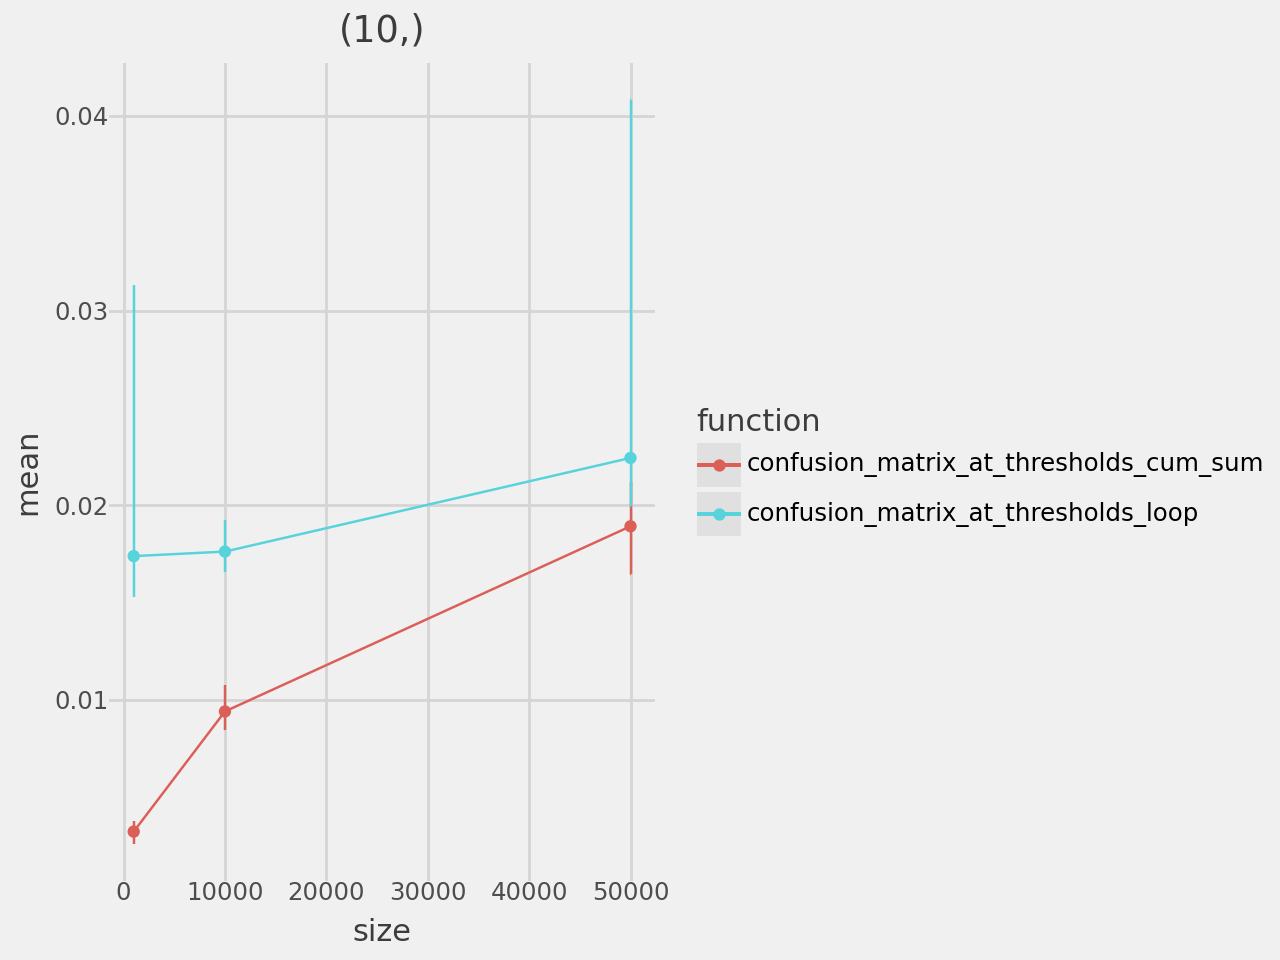

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


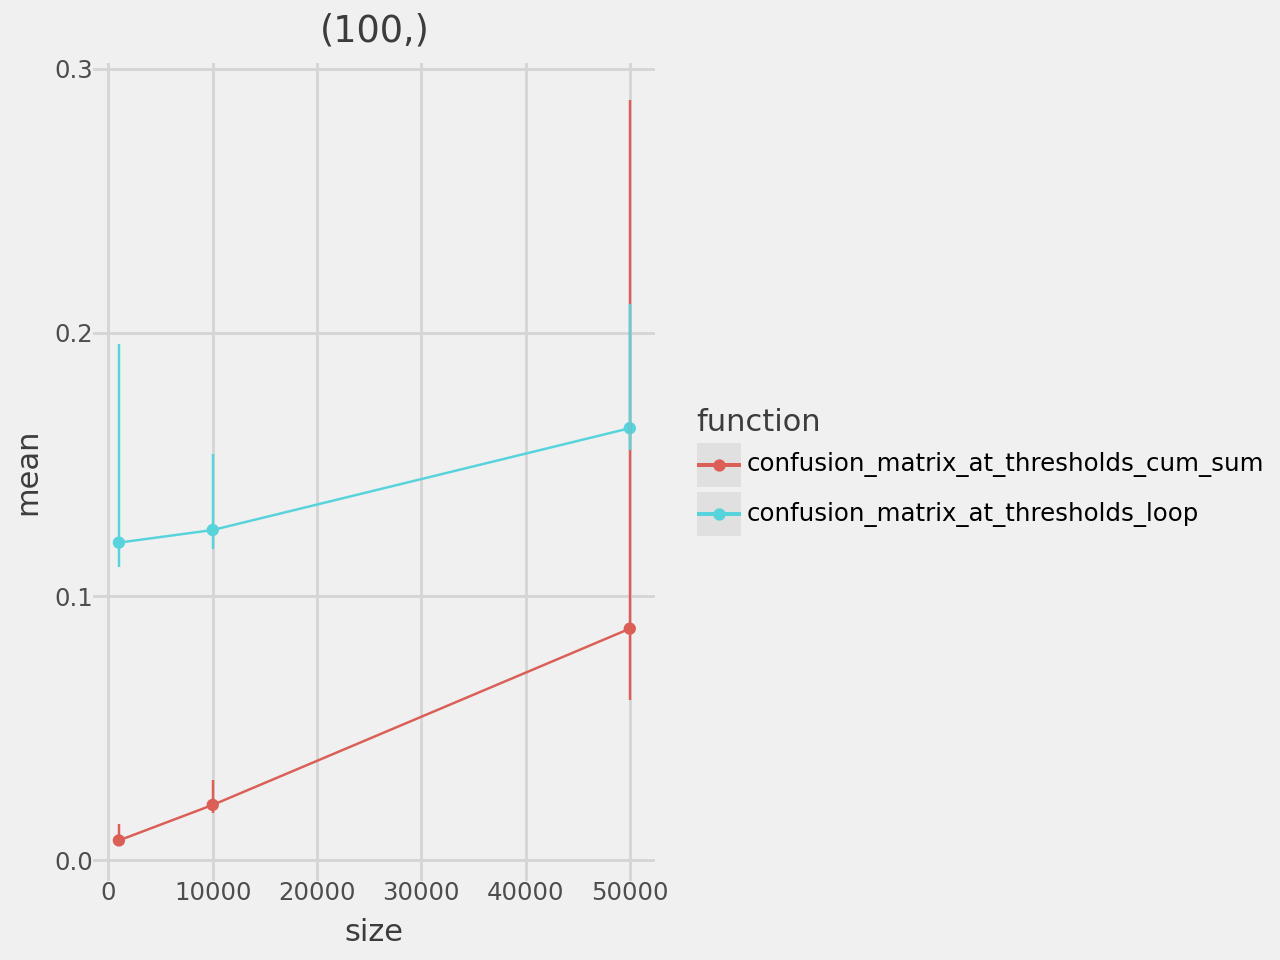

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


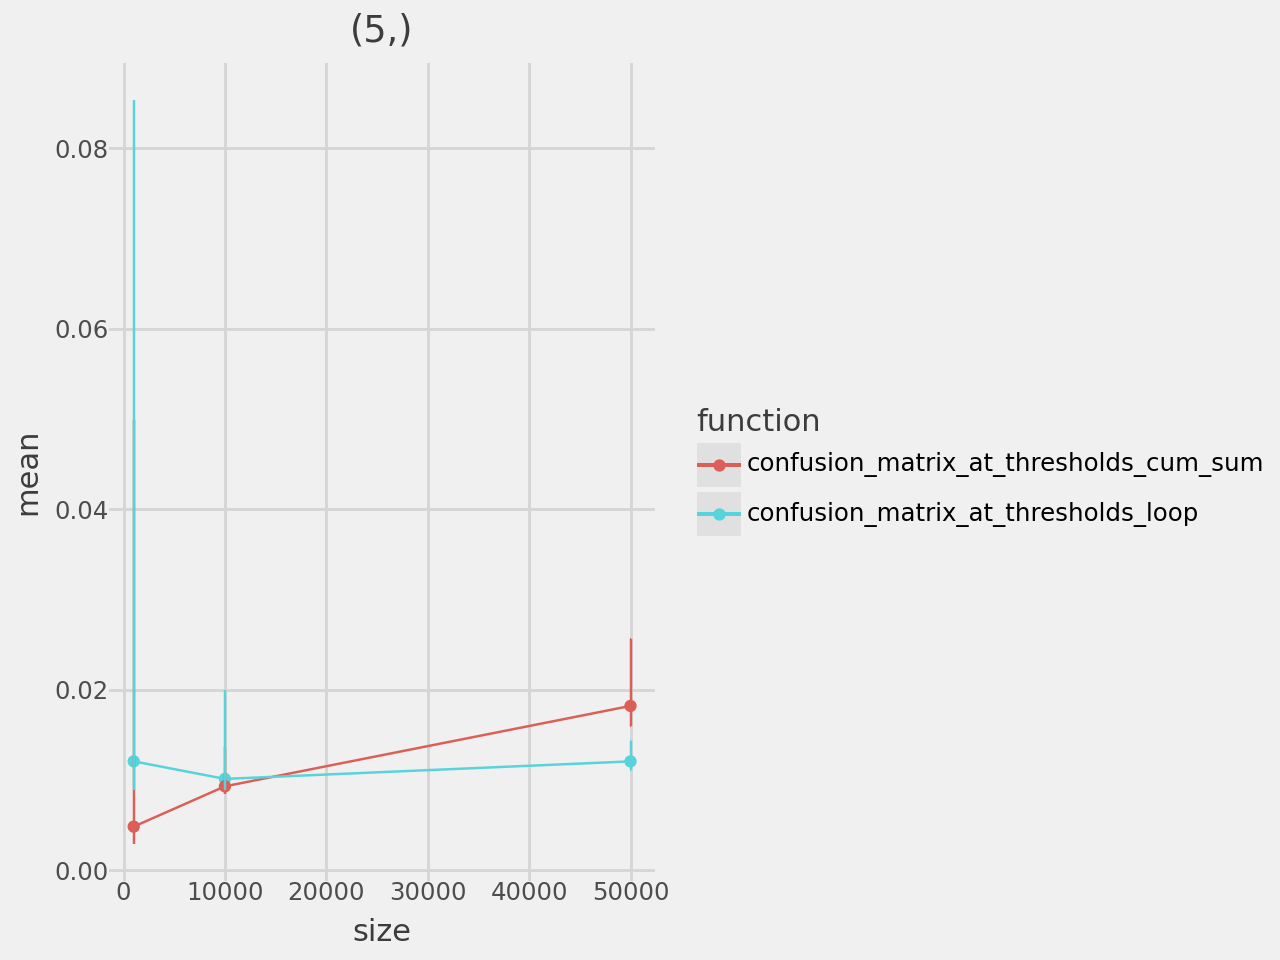

In [26]:
for n_t, tmp in x.partition_by("n_thresholds", as_dict=True).items():
    display(tmp.pipe(compare_over_sizes) + p9.ggtitle(n_t))

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


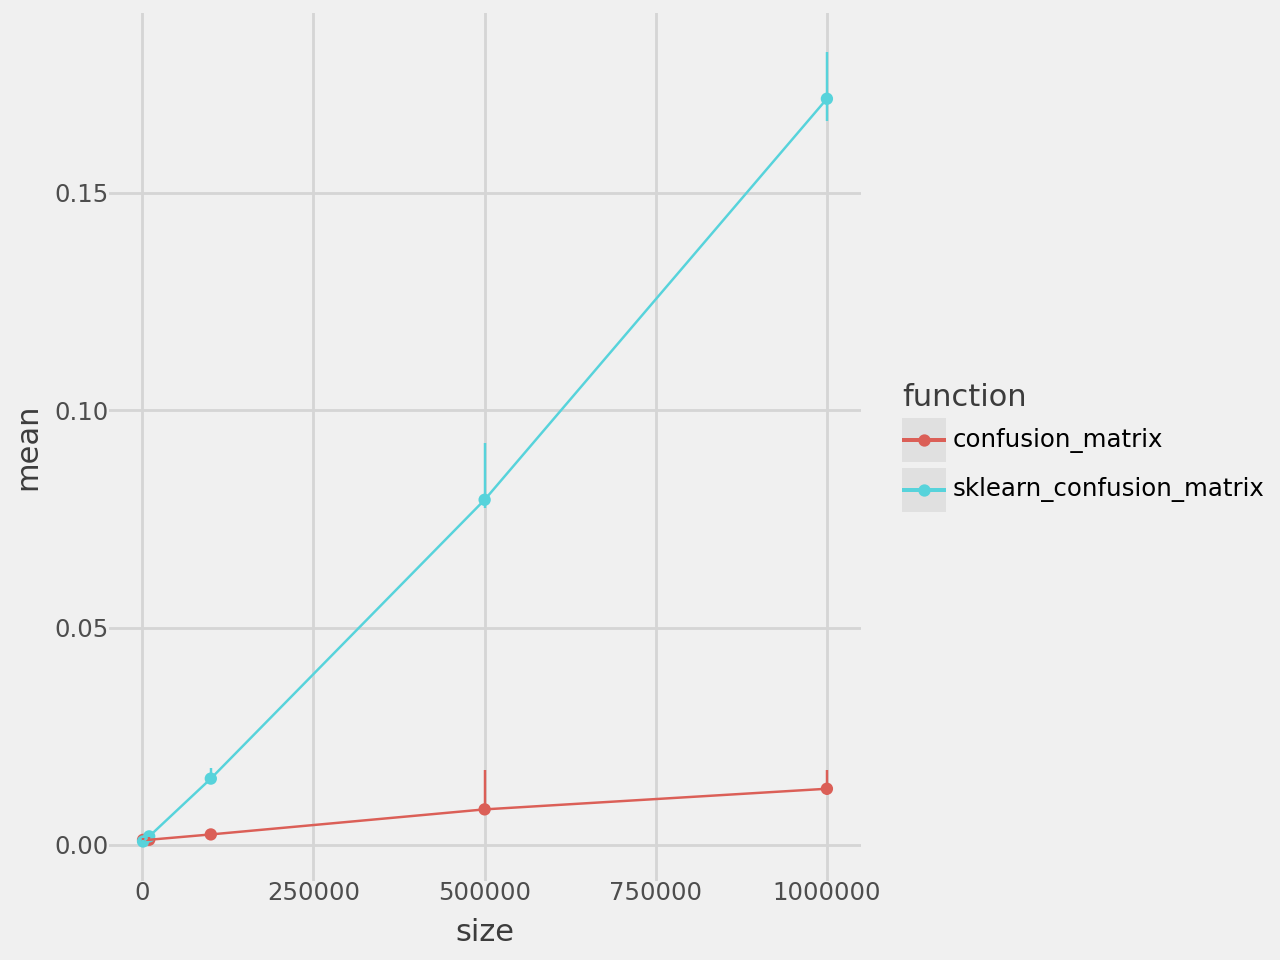

In [4]:
(
    recent.filter(
        pl.col("function").str.ends_with("confusion_matrix"),
        pl.col("size").gt(100),
    ).pipe(compare_over_sizes)
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


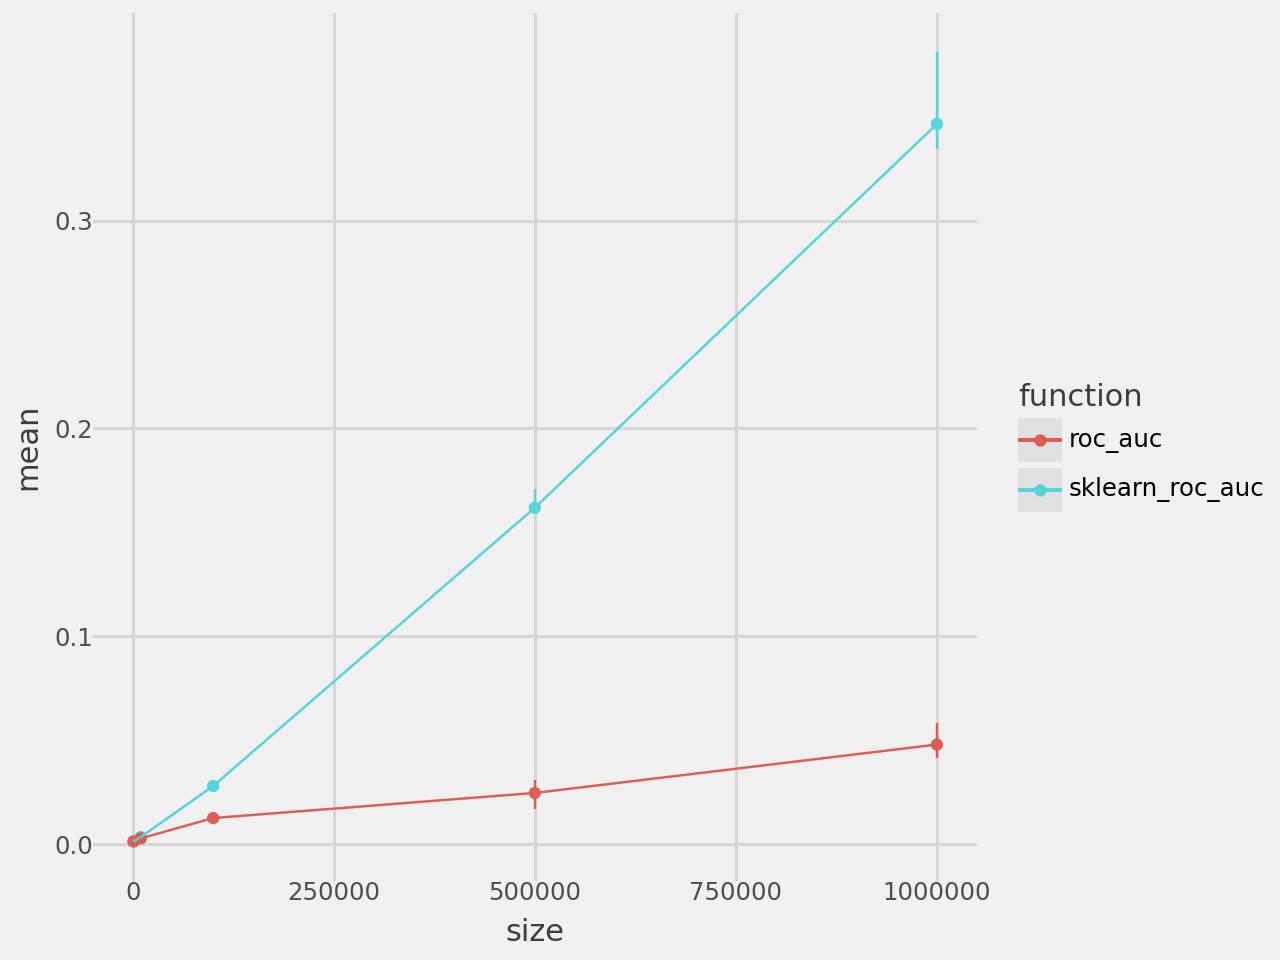

In [39]:
(
    recent.filter(
        pl.col("function").str.ends_with("roc_auc"),
        pl.col("size").gt(100),
    ).pipe(compare_over_sizes)
)

In [40]:
correlation_matrix = (
    recent.filter(pl.col("function").str.ends_with("correlation_matrix"))
    .with_columns(pl.col("parameters").str.json_decode())
    .unnest("parameters")
    .filter(pl.col("n_cols").eq(100))
    .drop("size")
    .rename({"n_rows": "size"})
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


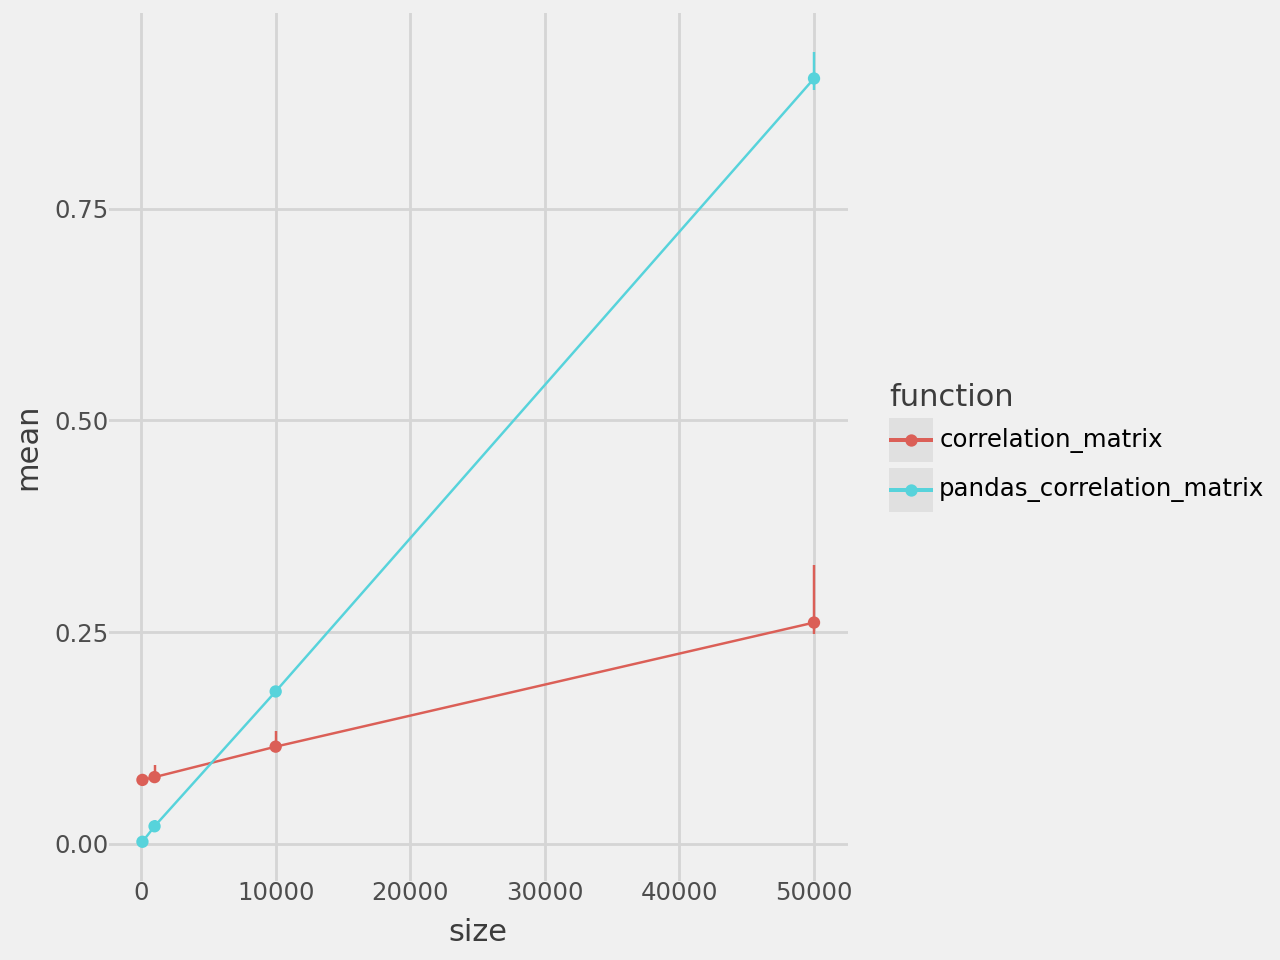

In [41]:
correlation_matrix.pipe(compare_over_sizes)